### AIM: Extract Time-Frequency object from EEG data and store in Numpy array for each participant's first session

To see how the frequency distribution and decimation parameter were selected see decimation_and_freqs_param_selection.ipynb in the background_notebooks subdirectory

In [1]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_morlet, tfr_multitaper
%matplotlib inline

In [2]:
# prevent extensive logging
mne.set_log_level('WARNING')

In [3]:
# set folder containing participants data as working directory
participants_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data"
os.chdir(participants_dir)
os.getcwd()

'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\TDBRAIN_participants_V2_data'

In [4]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }


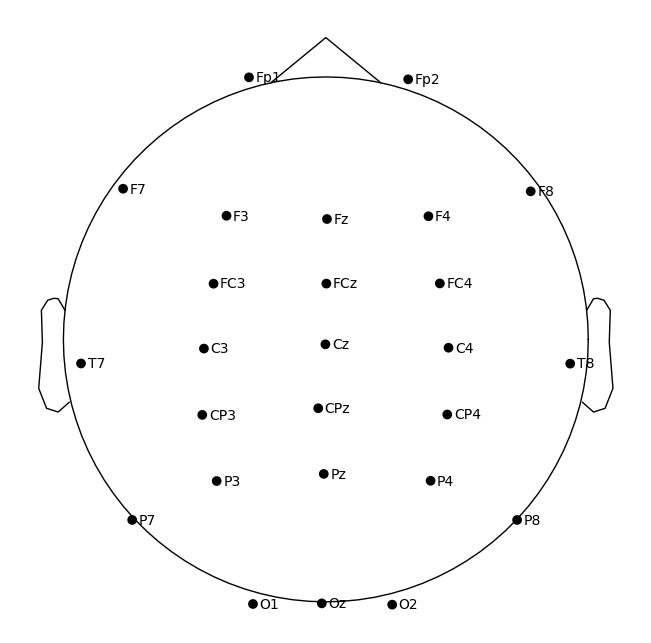

In [5]:
## Set montage and plot electrodes (Copied from Anne van Duijvenbode)

montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')
mne.viz.plot_montage(montage = montage, scale_factor=10, show_names=True, show=True, sphere='eeglab')

montage.save('montage_eeg.fif', overwrite = True)

In [6]:
# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


# Time-frequency analysis

First for singular participant to determine workflow:

In [7]:
# load data and create epochs
eeg_data_path = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-88078657\ses-1\eeg\sub-88078657_ses-1_task-restEC_eeg.csv'
eeg_data = pd.read_csv(eeg_data_path, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
raw.notch_filter(50)
raw.filter(0.5, 100)
        
epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?
print(epochs)

<Epochs |  12 events (good & bad), 0 – 9.998 s, baseline off, ~40 kB, data not loaded,
 '1': 12>


### Morlet wave convolution

In [8]:
# define frequencies of interest
freqs = np.array([ # 5 steps per frequency band
    0.5, 1.125, 1.75, 2.375, 3, # delta 
    4, 4.75, 5.5, 6.25, 7, # theta
    8, 9, 10, 11, 12, # alpha
    13, 17.25, 21.5, 25.75, 30, # beta
    42, 54, 66, 78, 90 # gamma
    ]) 
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR = tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)
epochsTFR.apply_baseline((0, 0.5), mode='mean') # baseline correction

power, itc= tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    average=True,
    decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)
power.apply_baseline((0, 0.5), mode='mean') # baseline correction

<AverageTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], nave : 12, channels : 26, ~3.1 MB>

In [9]:
print(epochsTFR) # TFR for each epoch seperate
print(power) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~37.2 MB>
<AverageTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], nave : 12, channels : 26, ~3.1 MB>


### Multitaper method

In [10]:
# define frequencies of interest
freqs = np.array([ # 5 steps per frequency band
    0.5, 1.125, 1.75, 2.375, 3, # delta 
    4, 4.75, 5.5, 6.25, 7, # theta
    8, 9, 10, 11, 12, # alpha
    13, 17.25, 21.5, 25.75, 30, # beta
    42, 54, 66, 78, 90 # gamma
    ]) 
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=False,
    average=False,
    decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)
epochsTFR_mt.apply_baseline((0, 0.5), mode='mean') # baseline correction

power_mt, itc_mt= tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=True,
    average=True,
    decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)
power_mt.apply_baseline((0, 0.5), mode='mean') # baseline correction

<AverageTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], nave : 12, channels : 26, ~3.1 MB>

In [11]:
print(epochsTFR_mt) # TFR for each epoch seperate
print(power_mt) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~37.2 MB>
<AverageTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], nave : 12, channels : 26, ~3.1 MB>


### Comparing Morlet vs Multitaper

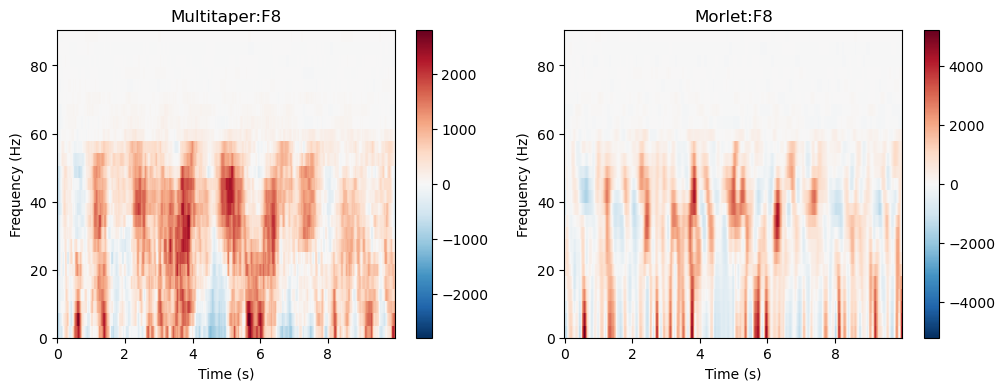

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

power_mt.plot([6], axes=ax1, show=False)
power.plot([6], axes=ax2, show=False)
ax1.set_title(f'Multitaper:{ch_names[6]}')
ax2.set_title(f'Morlet:{ch_names[6]}')
plt.show()

Text(0.5, 0.98, 'Morlet')

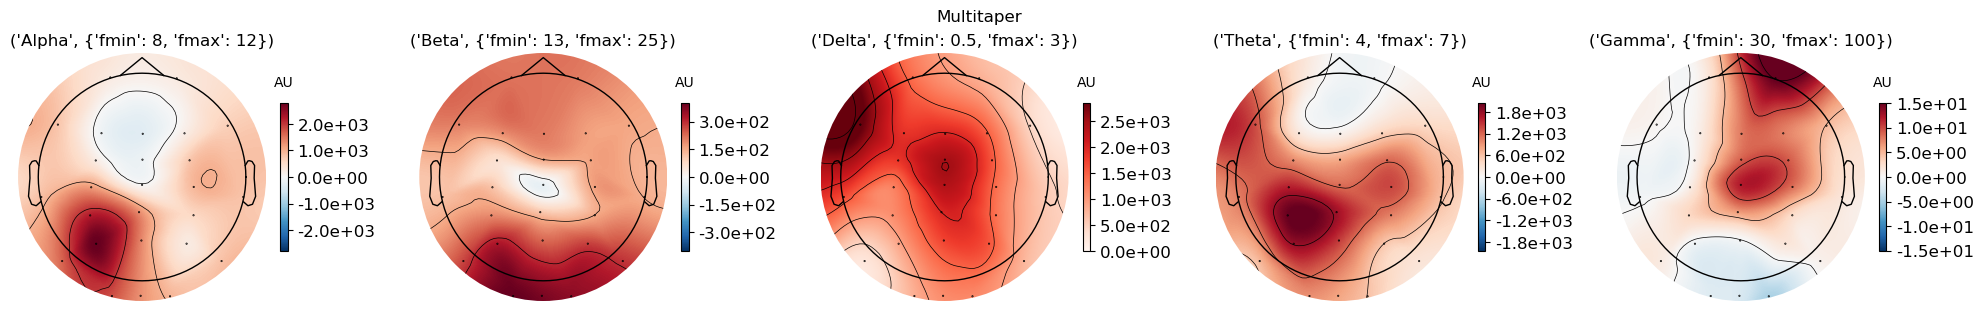

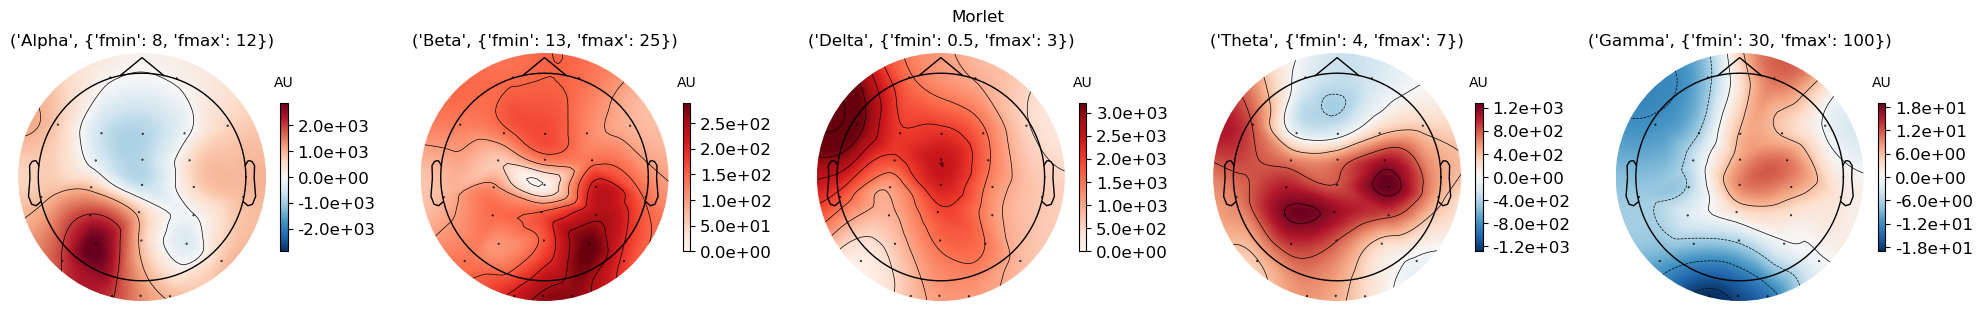

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=1, tmax=2, show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power_mt.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title((title, fmin_fmax))
fig.suptitle('Multitaper')

fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=1, tmax=2, show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title((title, fmin_fmax))
fig.suptitle('Morlet')


#### Check if TFR objects can be correctly stored and retrieved in/from numpy arrays

In [14]:
# try storing the MNE TFR object in numpy arrays and see if TFR object is correctly retrieved
a = np.array(power_mt) # storing as object
b = np.array(power_mt)
c = np.append(a, b)
print(c.shape)
c[0].info # data is correctly stored and retrieved from object in numpy array

(2,)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,29 points
Good channels,26 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,62.50 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [15]:
# try appending two multidimensional numpy arrays containing EpochsTFR data and check size
a = np.array([epochsTFR_mt])
b = np.array([epochsTFR_mt])
c = np.append(a, b, axis=0)
print(f'{c.shape = }')
print(f'{c.nbytes = }')

extracted_epochsTFR = c[0]
print(f'{extracted_epochsTFR.nbytes = }')
print(f'{extracted_epochsTFR.shape = }')

np.save('test_array_a.npy', c) # 76 MB
print('.npy file is 76 MB. If storing for all 1350 participants, I would need 102 GB of storage')

c.shape = (2, 12, 26, 25, 625)
c.nbytes = 78000000
extracted_epochsTFR.nbytes = 39000000
extracted_epochsTFR.shape = (12, 26, 25, 625)


.npy file is 76 MB. If storing for all 1350 participants, I would need 102 GB of storage


In [16]:
# try appending two multidimensional numpy arrays containing AverageTFR data and check size
a = np.array([power_mt])
b = np.array([power_mt])
c = np.append(a, b, axis=0)
print(f'{c.shape = }')
print(f'{c.nbytes = }')

extracted_power = c[0]
print(f'{extracted_power.data.nbytes = }') # averageTFR object can be stored as actual MNE object instead of as array, this is not the case for the epochsTFR object
print(f'{extracted_power.data.shape = }')

np.save('test_array_b.npy', c) # 3.2 MB
print('.npy file is 3.2 MB. More managable. If storing for all 1350 participants, I would need 4.3 GB of storage')

c.shape = (2,)
c.nbytes = 16
extracted_power.data.nbytes = 3250000
extracted_power.data.shape = (26, 25, 625)
.npy file is 3.2 MB. More managable. If storing for all 1350 participants, I would need 4.3 GB of storage


#### Check if there are first sessions with a much lower or higher scan duration, and therefore more or less than 12 epochs

In [17]:
# define directory
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives"

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    for file in files:
        if 'ses-1' in file: # filter first session
            #print(os.path.join(subdir, file))
            filepath = os.path.join(subdir, file)
            eeg_data = pd.read_csv(filepath, sep=',')
            eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

            raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
            raw.notch_filter(50)
            raw.filter(0.5, 100)
            #raw.info

            epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0) # create epochs

            if epochs.get_data().shape[0] > 12 or epochs.get_data().shape[0] < 12: # if more or less than 12 epochs
                scan_durn = raw._data.shape[1] / raw.info['sfreq'] # calculate scan duration
                print(f'Duration of EEG recording = {scan_durn} s, or {scan_durn / 60} min, # of epochs = {epochs.get_data().shape[0]}, {file = }')


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [18]:
# check for the participants that have less or more than 12 epochs for a certain session, if their second session (if available) does contain 12 epochs
# define directory
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives"

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    for file in files:
        if 'sub-88019613' in file or 'sub-88022493' in file or 'sub-88049673' in file: # filter participants with less or more than 12 epochs in first session
            if 'ses-2' in file: # filter 2nd session
                #print(os.path.join(subdir, file))
                filepath = os.path.join(subdir, file)
                eeg_data = pd.read_csv(filepath, sep=',')
                eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

                raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
                raw.notch_filter(50)
                raw.filter(0.5, 100)
                #raw.info

                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0) # create epochs

                scan_durn = raw._data.shape[1] / raw.info['sfreq'] # calculate scan duration
                print(f'Duration of EEG recording = {scan_durn} s, or {scan_durn / 60} min, # of epochs = {epochs.get_data().shape[0]}, {file = }')
            else:
                print('No 2nd session available')

No 2nd session available
No 2nd session available
No 2nd session available
No 2nd session available
No 2nd session available
No 2nd session available


Three participants have more or less than 12 epochs in either their EC or EO trial in their first session. Unfortunately, there are no recordings for these participants from a 2nd session, and therefore cannot be replaced.

In [19]:
# checking the quality of the ~209 second recording of participant sub-88022493
file_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-88022493\ses-1\eeg\sub-88022493_ses-1_task-restEC_eeg.csv"

eeg_data = pd.read_csv(file_dir, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
raw.notch_filter(50)
raw.filter(0.5, 100)

raw.plot(duration=200, n_channels=26) # large artificats in mostly the first 80-90 seconds

### Now, use the workflow for a single participant to create loop for all participants 

~190 GB of storage space needed!

In [20]:
# calculate multitaper and morlet epochsTFR for each participant's first session EC & EO, store in numpy array and save in output folder as .npy file

# In case there any participants we want to exlude from the analysis, we can define their IDs here.
# However, the code already takes care of participants with less or more than 12 epochs in the first session, so these do not have to be excluded here.
exclude_ids = [] # no participants to exclude for now

# define a padding function, in case the number of epochs is not equal to 12
def pad_array(arr, target_shape):
    padding = [(0, target_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
    return np.pad(arr, padding, 'constant')

# define the target shape
target_shape = (12, 26, 25, 625) # 12 epochs, 26 channels, 25 frequencies, 625 time points (decimated by 8 from 5000 Hz to 625 Hz)

# define frequencies of interest
freqs = np.array([ # 5 steps per frequency band
    0.5, 1.125, 1.75, 2.375, 3, # delta 
    4, 4.75, 5.5, 6.25, 7, # theta
    8, 9, 10, 11, 12, # alpha
    13, 17.25, 21.5, 25.75, 30, # beta
    42, 54, 66, 78, 90 # gamma
    ]) 
n_cycles = freqs / 2.0 # different number of cycles per frequency

# Initialize counter before the loop for showing progress
counter = 0
total_ses_1_files = '~2700'

# define directories
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives"
morlet_output_dir = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\TFR_morlet_output'
multitaper_output_dir = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\TFR_multitaper_output'

# Initialize the arrays before the loop to none, so we can check if EC files are missing
ec_tfr_morlet_arr = None
ec_tfr_mt_arr = None

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    for file in files:
        if not any(exclude_id in file for exclude_id in exclude_ids): # filter out participants to exclude
            if 'ses-1' in file: # filter first session
                #print(os.path.join(subdir, file))
                filepath = os.path.join(subdir, file)
                eeg_data = pd.read_csv(filepath, sep=',')
                eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

                raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
                raw.notch_filter(50)
                raw.filter(0.5, 100)
                #raw.info

                # epoch the data and compute PSD
                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0) # overlap 0?

                # calculate PSD using Welch's method
                #psd_epochs = epochs.compute_psd(method = 'welch', fmin = 0.25, fmax = 110, picks = 'eeg', average = 'mean') # not sure which fmin and fmax to use?
                
                # perform Time-frequency analysis using Morlet wave convolution
                tfr_morlet_object = tfr_morlet(
                    epochs,
                    freqs=freqs,
                    n_cycles=n_cycles,
                    use_fft=True,
                    return_itc=False,
                    average=False,
                    decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor
                    n_jobs=-1)
                tfr_morlet_object.apply_baseline((0, 0.5), mode='mean') # baseline correction

                # perform Time-frequency analysis using the Multitaper method
                tfr_mt_object = tfr_multitaper(
                    epochs,
                    freqs=freqs,
                    n_cycles=n_cycles,
                    time_bandwidth=4, # just random for now
                    use_fft=True,
                    return_itc=False,
                    average=False,
                    decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor
                    n_jobs=-1)
                tfr_mt_object.apply_baseline((0, 0.5), mode='mean') # baseline correction
                
                # split file name to obtain ID and session number
                ID = str(file.split('_')[0])
                #print(ID)
                sessID = str(file.split('_')[1])
                #print(sessID)
                
                # add TFR objects to numpy array
                if 'EC' in file:
                    ec_tfr_morlet_arr = np.array([tfr_morlet_object])
                    ec_tfr_mt_arr = np.array([tfr_mt_object])
                if 'EO' in file:
                    # Check if the EC arrays are not None before appending and saving
                    if ec_tfr_morlet_arr is not None and ec_tfr_mt_arr is not None:
                        eo_tfr_morlet_arr = np.array([tfr_morlet_object])
                        eo_tfr_mt_arr = np.array([tfr_mt_object])
                        
                        # Check if the number of epochs is more than target_shape[0] (12)
                        if ec_tfr_morlet_arr.shape[0] > target_shape[0] or eo_tfr_morlet_arr.shape[0] > target_shape[0]:
                            print(f"Warning: More than 12 epochs found for participant {ID}. Skipping this participant.")
                            # Reset the EC arrays to None for the next iteration
                            ec_tfr_morlet_arr = None
                            ec_tfr_mt_arr = None
                            continue
                        
                        # Check if the number of epochs is less than target_shape[0] (12)
                        if ec_tfr_morlet_arr.shape[0] < target_shape[0] or eo_tfr_morlet_arr.shape[0] < target_shape[0]:
                            print(f"Warning: Less than 12 epochs found for participant {ID}, file {file}. Padding array to {target_shape[0]} epochs.")

                        # pad arrays to target shape if object has less than 12 epochs
                        if ec_tfr_morlet_arr.shape != target_shape:
                            ec_tfr_morlet_arr = pad_array(ec_tfr_morlet_arr, target_shape)
                        if ec_tfr_mt_arr.shape != target_shape:
                            ec_tfr_mt_arr = pad_array(ec_tfr_mt_arr, target_shape)
                        if eo_tfr_morlet_arr.shape != target_shape:
                            eo_tfr_morlet_arr = pad_array(eo_tfr_morlet_arr, target_shape)
                        if eo_tfr_mt_arr.shape != target_shape:
                            eo_tfr_mt_arr = pad_array(eo_tfr_mt_arr, target_shape)

                        # EO file is always after EC file, and all first sessions have both EO and EC data,
                        # so after each EO file we can append the EO/EC arrays and save them as .npy file
                        tfr_morlet_arr = np.append(ec_tfr_morlet_arr, eo_tfr_morlet_arr, axis=0)
                        tfr_mt_arr = np.append(ec_tfr_mt_arr, eo_tfr_mt_arr, axis=0)
                        np.save(f'{morlet_output_dir}\{ID}_{sessID}_tfr-morlet.npy', tfr_morlet_arr)
                        np.save(f'{multitaper_output_dir}\{ID}_{sessID}_tfr-multitaper.npy', tfr_mt_arr)
                        
                        # Reset the EC arrays to None for the next iteration
                        ec_tfr_morlet_arr = None
                        ec_tfr_mt_arr = None
                    else:
                        print(f"Warning: EO file {file} found without preceding EC file.")

                # Increment the counter and print it
                counter += 1
                print(f"\rProcessing file {counter} of {total_ses_1_files}", end="")
                



Processing file 1 of 2

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.